In [13]:
from functools import partial
from numbers import Complex
from typing import Callable
from math import pi, e

import time
import PIL
import glob
import imageio
import matplotlib.pyplot as plt 
import numpy as np


In [2]:
def douady_hubbard_polynomial(z: Complex,
                              c: Complex) -> Complex:
    """
    Monic and centered quadratic complex polynomial
    https://en.wikipedia.org/wiki/Complex_quadratic_polynomial#Map
    """
    return z ** 2 + c

In [3]:
def Circle_Path(radius, iterations):
    r = radius
    c_n = []
    circle = 2*pi
    for t in range(iterations):
        c = r*e**(t * circle/iterations * 1j)
        c_n.append(c)
    return c_n

In [4]:
def julia_set(mapping: Callable[[Complex], Complex], 
            *, 
            min_coordinate: Complex, 
            max_coordinate: Complex, 
            width: int, 
            height: int, 
            iterations_count: int = 256, 
            threshold: float = 2.) -> np.ndarray:
    im, re = np.ogrid[min_coordinate.imag: max_coordinate.imag: height * 1j, min_coordinate.real: max_coordinate.real: width * 1j]

    z = (re + 1j * im).flatten()

    live, = np.indices(z.shape)
    iterations = np.empty_like(z, dtype=int)

    for i in range(iterations_count):
        z_live = z[live] = mapping(z[live])
        escaped = abs(z_live) > threshold
        iterations[live[escaped]] = i
        live = live[~escaped]
        if live.size == 0:
            break
    else: 
        iterations[live] = iterations_count

    return iterations.reshape((height, width))


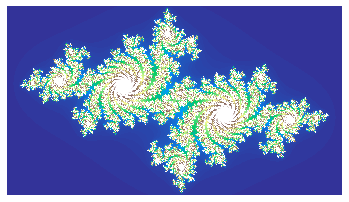

In [5]:
if __name__ == '__main__':
    mapping = partial(douady_hubbard_polynomial, c=-0.7 + 0.27015j)

    image = julia_set(mapping, min_coordinate=-1.6-0.9j, max_coordinate=1.6+0.9j,width=1920, height=1080)

    plt.axis('off')
    plt.imshow(image, cmap='terrain', origin='lower')
    plt.show()

In [6]:
def animator(Gif_out):
    with imageio.get_writer(Gif_out, mode='I') as writer:
        filenames = glob.glob('plot*.png')
        filenames = sorted(filenames)
        print(filenames)
        last = -1
        for i, filename in enumerate(filenames):
            frame = 2*(i**0.5)
            if round(frame) > round(last):
                last = frame
            else: 
                continue
            image = imageio.imread(filename)
            writer.append_data(image)

In [14]:
def generate_images(func, radius:int , iters: int, width, height, min_coord: Complex, max_coord: Complex):
    
    c_n = Circle_Path(radius, iters)

    for i in range(iters):
        tik = time.time()
        mapping = partial(func, c = c_n[i])

        image = julia_set(mapping, 
                min_coordinate= min_coord, 
                max_coordinate= max_coord, 
                width=width, 
                height=height)
        plt.axis('off')
        plt.imshow(image, cmap='terrain')
        plt.savefig('plot_{:04d}.png'.format(i), dpi=400)
        tok = time.time()
        elapsed = tok - tik
        print("Time for Plot_{:04d} = {}".format(i, elapsed))

In [16]:
def sample_plot(func, radius, width, height, min_coord, max_coord):
    
    c_n = Circle_Path(radius, 16)
    examples = []
    for i in range(16): 
        mapping = partial(func, c = c_n[i])
        example = julia_set(mapping, 
        min_coordinate=min_coord, 
        max_coordinate=max_coord,
        width=width,
        height=height)
        examples.append(example)
        
    
    fig = plt.figure(figsize=(4,4))
    for i in range(16):
        plt.axis('off')
        plt.subplot(4,4, i+1)
        plt.imshow(examples[i], cmap='terrain')
    plt.show()

In [9]:
def tan_func(z: Complex, c: Complex) -> Complex:
    return np.tan(z) ** 3 + c

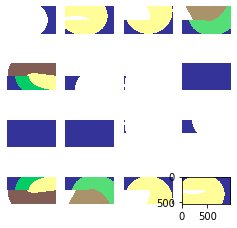

In [22]:
func = lambda z, c : z ** (1/2) + c
sample_plot(func,1,960,540,-1.5-1j,1.5+1j)

Time for Plot_0000 = 1.9158782958984375
Time for Plot_0001 = 2.256964921951294
Time for Plot_0002 = 2.8982508182525635
Time for Plot_0003 = 3.066801071166992
Time for Plot_0004 = 3.191467761993408
Time for Plot_0005 = 3.563472032546997
Time for Plot_0006 = 3.6781678199768066
Time for Plot_0007 = 3.9175243377685547
Time for Plot_0008 = 4.251633882522583
Time for Plot_0009 = 4.562800884246826
Time for Plot_0010 = 4.900896787643433
Time for Plot_0011 = 5.182145357131958
Time for Plot_0012 = 5.394577980041504
Time for Plot_0013 = 5.780545711517334
Time for Plot_0014 = 5.97402811050415
Time for Plot_0015 = 6.345036029815674
Time for Plot_0016 = 6.697094678878784
Time for Plot_0017 = 6.963382959365845
Time for Plot_0018 = 7.301477432250977
Time for Plot_0019 = 7.697420835494995
Time for Plot_0020 = 7.835052251815796
Time for Plot_0021 = 8.213041543960571
Time for Plot_0022 = 8.597014665603638
Time for Plot_0023 = 9.019885301589966
Time for Plot_0024 = 9.408844709396362
Time for Plot_0025 = 1

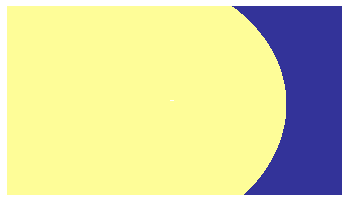

In [23]:
generate_images(func,1,100,3840,2160,-1.5-1j,1.5+1j)
Gif_out = 'douady.gif'
animator(Gif_out)

In [171]:
def generate_mandelbrot(func, width, height, min_coord, max_coord):
    
    mapping = partial(func, z = 1 + 0j)
    example = julia_set(mapping, 
        min_coordinate=min_coord, 
        max_coordinate=max_coord,
        width=width,
        height=height)

    plt.axis('off')
    plt.imshow(example, cmap='terrain')
    plt.show()